In [28]:
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
def sigmoid(x):
    x_return = 1 / (1+np.exp(-x))
    return x_return

def tanh(x):
    return np.tanh(x)

def dsigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def dtanh(x):
    return 1- np.tanh(x)*np.tanh(x)

def softmax(x):
    e_val = np.exp(x-np.max(x))
    sol = e_val/np.sum(e_val)
    return sol

def cross_entropy(softmax_output, target_index):
    log_li = -np.log(softmax_output[target_index])
    return log_li

def dcross_entropy(softmax_output, target_index):
    softmax_output[target_index] -= 1
    return softmax_output

def gradient_clip(updates):
    for varstr, grad in updates.items():
        a = np.clip(updates[varstr],-1,1)
        updates[varstr] = a
    return updates
    

In [30]:
class LSTM:
    """Naming follows colah blog and original paper
    http://colah.github.io/posts/2015-08-Understanding-LSTMs/
    http://www.bioinf.jku.at/publications/older/2604.pdf"""
    def __init__(self, hidden_state_size, input_size, seq_length):
        '''Constructor'''
        hid_input_conc_size = hidden_state_size + input_size
        self.var = {            
        'Ws': np.random.randn(input_size, hidden_state_size),
        'bs': np.zeros((input_size,1)),
        'Wo': np.random.randn(hidden_state_size,hid_input_conc_size),
        'bo': np.zeros((hidden_state_size,1)),
        'Wc': np.random.randn(hidden_state_size,hid_input_conc_size),
        'bc': np.zeros((hidden_state_size,1)),
        'Wi': np.random.randn(hidden_state_size,hid_input_conc_size),
        'bi': np.zeros((hidden_state_size,1)),
        'Wf': np.random.randn(hidden_state_size,hid_input_conc_size),
        'bf': np.zeros((hidden_state_size,1)),
        'hidden_state': np.zeros((hidden_state_size,1)),
        'cell_state': np.zeros((hidden_state_size,1))}
            
        """self.cell_state = np.zeros((hidden_state_size,1))
        self.hidden_state = np.zeros((hidden_state_size,1))
        hid_input_conc_size = hidden_state_size + input_size
        
        #input_gate_weights
        self.Wi = np.random.randn((hidden_state_size,hid_input_conc_size))
        self.bi = np.zeros((hidden_state_size,1))
        
        #forget_gate_weights
        self.Wf = np.random.randn((hidden_state_size,hid_input_conc_size))
        self.bf = np.zeros((hidden_state_size,1))

        #cell_gate_weights for "candidate values"
        self.Wc = np.random.randn((hidden_state_size,hid_input_conc_size))
        self.bc = np.zeros((hidden_state_size,1))

        #output_gate_weights
        self.Wo = np.random.randn((hidden_state_size,hid_input_conc_size))
        self.bo = np.zeros((hidden_state_size,1))
        
        #one more layer for input to softmax, cannot have enough of these
        self.Ws = np.random.randn((input_size, hidden_state_size))
        self.bs = np.zeros((input_size,1))"""
        
        self.memo = {
            'C_old': np.zeros((self.var['cell_state'].shape[0],seq_length)),
            'hx': np.zeros((hid_input_conc_size, seq_length)),
            'i_t': np.zeros((hidden_state_size, seq_length)),
            'f_t': np.zeros((hidden_state_size, seq_length)),
            'c_t': np.zeros((hidden_state_size, seq_length)),
            'o_t': np.zeros((hidden_state_size, seq_length)),
            'C_t': np.zeros((hidden_state_size, seq_length)),
            'hidden_state_t': np.zeros((hidden_state_size, seq_length))
            
        }
        self.updates = {            
            'Ws': np.zeros_like(self.var['Ws']),
            'bs': np.zeros_like(self.var['bs']),
            'Wo': np.zeros_like(self.var['Wo']),
            'bo': np.zeros_like(self.var['bo']),
            'Wc': np.zeros_like(self.var['Wc']),
            'bc': np.zeros_like(self.var['bc']),
            'Wi': np.zeros_like(self.var['Wi']),
            'bi': np.zeros_like(self.var['bi']),
            'Wf': np.zeros_like(self.var['Wf']),
            'bf': np.zeros_like(self.var['bf']),
            'hidden_state': np.zeros_like(self.var['hidden_state']),
            'cell_state': np.zeros_like(self.var['cell_state'])}
        
        
    def forward(self,X,timestep):
        
        cell_state = self.var['cell_state']
        self.memo['C_old'][:,timestep] = cell_state[:,0]
        
        hx = np.vstack((self.var['hidden_state'],X))
        i_t = sigmoid(np.dot(self.var['Wi'], hx)+self.var['bi'])
        f_t = sigmoid(np.dot(self.var['Wf'],hx)+self.var['bf'])
        c_t = tanh(np.dot(self.var['Wc'],hx)+self.var['bc'])
        o_t = sigmoid(np.dot(self.var['Wo'],hx)+self.var['bo'])
        
        Cf = cell_state * f_t
        Ci = i_t * c_t
        C_t = Cf + Ci
        #print(C_t.shape)
        self.var['cell_state'] = C_t
        
        hidden_state_t = tanh(C_t) * o_t
        
        s_t = np.dot(self.var['Ws'],hidden_state_t)+self.var['bs']
        
        output = softmax(s_t)
        
        self.memo['hx'][:,timestep] = hx[:,0]
        self.memo["i_t"][:,timestep] = i_t[:,0]
        self.memo['f_t'][:,timestep] = f_t[:,0]
        self.memo['c_t'][:,timestep] = c_t[:,0]
        self.memo['o_t'][:,timestep] = o_t[:,0]
        self.memo['C_t'][:,timestep] = C_t[:,0]
        self.memo['hidden_state_t'][:,timestep] = hidden_state_t[:,0]
        
        return output
    
    def backward(self, target_index, softmax_output,sequence_length):
        #print(softmax_output.shape)
        grad = np.copy(softmax_output)
        deltaL1 = dcross_entropy(grad, target_index).reshape(-1,1)
        #print(np.transpose(np.array(self.memo['hidden_state_t'][:,-1].reshape(-1,1))).shape)
        self.updates['Ws'] += np.dot(deltaL1, np.transpose(np.array(self.memo['hidden_state_t'][:,-1].reshape(-1,1))))
        self.updates['bs'] += deltaL1

        delta_wrt_h = np.dot(np.transpose(self.var['Ws']), deltaL1)
        #print(delta_wrt_h.shape)
        
        for timestep in reversed(range(sequence_length)):
            
            delta_wrt_h += self.updates['hidden_state']
            
            #print('ct', tanh(self.memo['C_t'][:,timestep]).shape)
            #print('ot', dsigmoid(self.memo['o_t'][:,timestep]).shape)
            
            delta_wrt_o = dsigmoid(self.memo['o_t'][:,timestep]).reshape(-1,1)*(delta_wrt_h * tanh(self.memo['C_t'][:,timestep]).reshape(-1,1))
            
            #print(delta_wrt_o.shape)
            #print(self.memo['hx'][:,timestep].shape)
            
            self.updates['Wo'] += np.dot(delta_wrt_o, np.transpose(self.memo['hx'][:,timestep].reshape(-1,1))) 
            self.updates['bo'] += delta_wrt_o

            
            delta_wrt_Ct = np.copy(self.updates['cell_state'])
            
            #print(self.updates['cell_state'])
            #print('ct', delta_wrt_Ct.shape)
            
            delta_wrt_Ct += self.memo['o_t'][:,timestep].reshape(-1,1)* delta_wrt_h * dtanh(tanh(self.memo['C_t'][:,timestep])).reshape(-1,1)
            delta_wrt_c = dtanh(self.memo['c_t'][:,timestep]).reshape(-1,1) * delta_wrt_Ct * self.memo['i_t'][:,timestep].reshape(-1,1)
            
            self.updates['Wc'] += np.dot(delta_wrt_c, np.transpose(self.memo['hx'][:,timestep].reshape(-1,1)))
            self.updates['bc'] += delta_wrt_c

            delta_wrt_i = dsigmoid(self.memo['i_t'][:,timestep]).reshape(-1,1) * delta_wrt_Ct * self.memo['c_t'][:,timestep].reshape(-1,1)
            
            self.updates['Wi'] += np.dot(delta_wrt_i, np.transpose(self.memo['hx'][:,timestep].reshape(-1,1)))
            self.updates['bi'] += delta_wrt_i

            delta_wrt_f = dsigmoid(self.memo['f_t'][:,timestep]).reshape(-1,1) * self.memo['C_old'][:,timestep].reshape(-1,1) * delta_wrt_Ct 
            self.updates['Wf'] += np.dot(delta_wrt_f, np.transpose(self.memo['hx'][:,timestep].reshape(-1,1)))
            self.updates['bf'] += delta_wrt_f
        
            delta_wrt_hx = (np.dot(np.transpose(self.var['Wf']), delta_wrt_f)
                 + np.dot(np.transpose(self.var['Wi']), delta_wrt_i)
                 + np.dot(np.transpose(self.var['Wc']), delta_wrt_c)
                 + np.dot(np.transpose(self.var['Wo']), delta_wrt_o))
        
            self.updates['hidden_state'] = delta_wrt_hx[:self.var['hidden_state'].shape[0], :]
            self.updates['cell_state'] = self.memo['f_t'][:,timestep].reshape(-1,1) * delta_wrt_Ct

        return self.updates
    
    def reset_updates(self):
        self.updates = {            
            'Ws': np.zeros_like(self.var['Ws']),
            'bs': np.zeros_like(self.var['bs']),
            'Wo': np.zeros_like(self.var['Wo']),
            'bo': np.zeros_like(self.var['bo']),
            'Wc': np.zeros_like(self.var['Wc']),
            'bc': np.zeros_like(self.var['bc']),
            'Wi': np.zeros_like(self.var['Wi']),
            'bi': np.zeros_like(self.var['bi']),
            'Wf': np.zeros_like(self.var['Wf']),
            'bf': np.zeros_like(self.var['bf']),
            'hidden_state': np.zeros_like(self.var['hidden_state']),
            'cell_state': np.zeros_like(self.var['cell_state'])}
    

In [31]:
def train(model,X, y,learning_rate):
    loss = []
    output = np.zeros((10,X.shape[1]))
    for t in range(X.shape[0]):
        for s in range(X.shape[1]):
            softmax_output = model.forward(np.array(one_hot_encoding(int(X[t,s]))).reshape(-1,1),s)
            output[:,s] = softmax_output[:,0]
        #print(output)
        #print(y)
        loss.append(cross_entropy(output[:,-1], int(y[t])))

        updates = model.backward(int(y[t]), output[:,-1],X.shape[1])
        updates = gradient_clip(updates)
        for varstr, grad in updates.items():
            model.var[varstr] = model.var[varstr] - (learning_rate * updates[varstr])
        model.reset_updates()
        
        
    return loss    

In [32]:
def one_hot_encoding(number):
    func = [[1,0,0,0,0,0,0,0,0,0],
            [0,1,0,0,0,0,0,0,0,0],
            [0,0,1,0,0,0,0,0,0,0],
            [0,0,0,1,0,0,0,0,0,0],
            [0,0,0,0,1,0,0,0,0,0],
            [0,0,0,0,0,1,0,0,0,0],
            [0,0,0,0,0,0,1,0,0,0],
            [0,0,0,0,0,0,0,1,0,0],
            [0,0,0,0,0,0,0,0,1,0],
            [0,0,0,0,0,0,0,0,0,1]]
    return func[number]

def generate_data_sequence(length=5):
    sequence = [random.choice(range(0,9)) for i in range(length)]
    sequence[0] = sequence[-1]
    return sequence

def generate_data_set(length_data_set, sequence_length):
    #sequence = generate_data_sequence(length = sequence_length)
    #data_set_X = np.array([one_hot_encoding(i) for i in sequence[:-1]])
    data_set_X = np.zeros((length_data_set,sequence_length-1))
    data_set_Y = np.zeros((length_data_set,1))
    #data_set_Y[0] = sequence[-1]
    for i in range(0,length_data_set):
        sequence = generate_data_sequence(length=sequence_length)
        data_set_X[i] = np.array(sequence[:-1])
        data_set_Y[i] = sequence[-1]
    return data_set_X, data_set_Y
    


In [42]:
sequence_length = 3

X, y = generate_data_set(1000,sequence_length)
lstm = LSTM(300,10,sequence_length-1)
loss = train(lstm, X, y, 0.1)

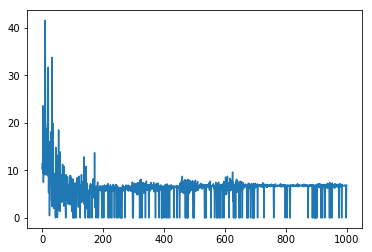

In [43]:
plt.plot(range(0,1000),loss)

plt.show()